<a href="https://colab.research.google.com/github/mrreyesm/FINANCIAL_ASSET_ANALYSIS/blob/main/FINANCIAL_ASSET_ANALYSIS_VISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##FINANCIAL ASSET ANALYSIS - VISA

# Libraries

In [ ]:
# For system related operations
import sys
# For Data Processing
import numpy as np
import pandas as pd
from tabulate import tabulate
# For Data Viz
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
# For Datetime
from datetime import datetime, timedelta
import time
# For sending GET requests from the API
import requests
# For dealing with json responses we receive from the API
import json
# For string manipulation
import string
import textwrap
# For yahoo finance
!{sys.executable} -m pip install yfinance
import yfinance as yf
# For Technical indicators
!{sys.executable} -m pip install -U git+https://github.com/twopirllc/pandas-ta
import pandas_ta as ta
# For modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https:/

# Master functions

In [ ]:
# Function to get basic and historical information of the stock
def stock_get_info(stock, years, plot = True):
  symbol = yf.Ticker(stock)
  recom = symbol.recommendations
  #Basic info
  longName = symbol.info["longName"]
  symb = symbol.info["symbol"]
  market = symbol.info["market"]
  sector = symbol.info["sector"]
  industry= symbol.info["industry"]
  longBusinessSummary = symbol.info["longBusinessSummary"]
  currency = symbol.info["currency"]
  currentPrice = symbol.info["currentPrice"]
  recommendationKey = symbol.info["recommendationKey"]
  print(f"Name: {longName} Symbol: {symb} Market: {market}")
  print(f"Sector: {sector} Industry: {industry}\n\nBusiness description:")
  wrapper = textwrap.TextWrapper(width=80)
  word_list = wrapper.wrap(text=longBusinessSummary)  
  for element in word_list:
      print(element)
  print(f"\nCurrent price: {currentPrice} Currency: {currency}")
  print(f"\nYahoo Finance Recommendation: {recommendationKey}\n")
  start_time = datetime.now() - timedelta(days=years*365)
  start_time = start_time.strftime("%Y-%m-%d")
  end_time = datetime.now()
  end_time = end_time.strftime("%Y-%m-%d")
  hist = symbol.history(start=start_time, end=end_time)
  hist['Daily_pct_change'] = hist['Close'].pct_change()
  hist["Daily_Volume_diff"] =  hist['Volume'].diff()
  hist = hist.iloc[1: , :]
  hist.drop(columns = ['Dividends', "Stock Splits"], inplace = True)
  indicators = hist.copy()
  indicators.ta.rsi(close='Close', append=True)
  indicators.ta.macd(close='Close', append=True)
  indicators['SMA_30'] = indicators.ta.sma(close='Close',length=30)
  indicators['SMA_100'] = indicators.ta.sma(close='Close',length=100)
  #indicators.ta.atr(close='Close', append=True)
  #indicators.ta.adx(close='Close', append=True)
  #---------------------------------------
  #indicators.ta.cci(close='Close', append=True)
  #indicators.ta.obv(close='Close', append=True)
  #indicators.ta.ad(close='Close', append=True)
  #indicators.ta.adx(close='Close', append=True)
  indicators.drop(columns = ["MACD_12_26_9", "MACDs_12_26_9"], inplace = True)
  indicators = indicators.sort_values(by = "Date", ascending = False)
  today = indicators.iloc[:1 , :]
  print(tabulate(today, headers='keys', tablefmt='psql'), "\n")
  if(plot):
    # Let's see a historical view of the closing price
    plt.rcParams['figure.figsize'] = (16,9)
    plt.subplot(2, 1, 1)
    hist['Close'].plot(legend=True)
    plt.title('Price History from YFinance API',fontsize=17)
    plt.ylabel('Price', fontsize=15)
    plt.xlabel('Date', fontsize=15)
    # Now let's plot the total volume of stock being traded each day
    plt.subplot(2, 1, 2)
    hist['Volume'].plot(legend=True)
    plt.title('Volume of Stock Sales History from YFinance API',fontsize=17)
    plt.ylabel('Volume', fontsize=15)
    plt.xlabel('Date', fontsize=15)
  return hist, recommendationKey, recom

In [ ]:
# Function to add the RSI indicator and the RSI signal for the model
def add_rsi_signal(hist, plot = True, showtables = True):
  hist.ta.rsi(close='Close', append=True, signal_indicators=True, xa=70, xb=30)
  hist = hist.sort_values(by = "Date", ascending = False)
  hist = hist.dropna(how='all') #drop rows with al NaNs
  hist = hist.dropna(subset=['RSI_14']) #drop ros with RSI = NaN
  hist.RSI_14_A_70 = hist.RSI_14_A_70.apply(lambda x: "SELL" if x == 1 else "HOLD")
  hist.RSI_14_B_30 = hist.RSI_14_B_30.apply(lambda x: "BUY" if x == 1 else "HOLD")
  hist['RSI_signal'] = np.where(hist.RSI_14_A_70 == "SELL", 'SELL', np.where(hist.RSI_14_B_30 == "BUY", 'BUY','HOLD'))
  counting = hist.groupby('RSI_signal').size().reset_index().rename(columns={0:'count'})
  if(showtables):
    print(tabulate(counting, headers='keys', tablefmt='psql'), "\n")
  hist["RSI_signal"] = hist["RSI_signal"].astype('category')
  hist['RSI_signal_factor'] = np.where(hist['RSI_signal'] == "BUY", 1, np.where(hist['RSI_signal'] == "HOLD", 2, 3))
  if(plot):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_width=[0.25, 0.75])
    fig.update_layout(           
      title={
          'text': "Relative Strength Index (RSI)",
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'})
    # Create Candlestick chart for price data
    fig.add_trace(go.Candlestick(
        x=hist.index,
        open=hist['Open'],
        high=hist['High'],
        low=hist['Low'],
        close=hist['Close'],
        increasing_line_color='#ff9900',
        decreasing_line_color='black',
        showlegend=False
        ), row=1, col=1)
    # Make RSI Plot
    fig.add_trace(go.Scatter(
        x=hist.index,
        y=hist['RSI_14'],
        line=dict(color='#ff9900', width=2),
        showlegend=False,
    ), row=2, col=1
    )
    # Add upper/lower bounds
    fig.update_yaxes(range=[-10, 110], row=2, col=1)
    fig.add_hline(y=0, col=1, row=2, line_color="#666", line_width=2)
    fig.add_hline(y=100, col=1, row=2, line_color="#666", line_width=2)

    # Add overbought/oversold
    fig.add_hline(y=30, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
    fig.add_hline(y=70, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
    # Customize font, colors, hide range slider
    layout = go.Layout(
        plot_bgcolor='#efefef',
        # Font Families
        font_family='Monospace',
        font_color='#000000',
        font_size=20,
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        )
    )
    # update and display
    fig.update_layout(layout)
    fig.show()
  print("\n")
  hist.drop(columns=["RSI_14_A_70", "RSI_14_B_30",'RSI_signal', "RSI_14"], inplace = True)
  if(showtables):
    print(tabulate(hist.iloc[:3 , :], headers='keys', tablefmt='psql'), "\n")
  return hist

In [ ]:
def add_MACD_signal(hist, plot = True, showtables = True):
    hist.ta.macd(close='close', fast=12, slow=26, append=True)
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(hist)):
        if hist['MACD_12_26_9'][i] > hist['MACDs_12_26_9'][i] :
            MACD_Sell.append(0)
            if position ==False:
                MACD_Buy.append(1)
                position=True
            else:
                MACD_Buy.append(0)
        elif hist['MACD_12_26_9'][i] < hist['MACDs_12_26_9'][i] :
            MACD_Buy.append(0)
            if position == True:
                MACD_Sell.append(1)
                position=False
            else:
                MACD_Sell.append(0)
        elif position == True and hist['Close'][i] < MACD_Buy[-1]:
            MACD_Sell.append(1)
            MACD_Buy.append(0)
            position = False
        elif position == True and hist['Close'][i] < hist['Close'][i - 1]:
            MACD_Sell.append(1)
            MACD_Buy.append(0)
            position = False
        else:
            MACD_Buy.append(0)
            MACD_Sell.append(0)
    hist['MACD_Buy_Signal_price'] = MACD_Buy
    hist['MACD_Sell_Signal_price'] = MACD_Sell
    hist['MACD_Signal'] = np.where(hist.MACD_Buy_Signal_price == 1, 'BUY', np.where(hist.MACD_Sell_Signal_price == 1, 'SELL','HOLD'))
    counting = hist.groupby(['MACD_Signal']).size().reset_index().rename(columns={0:'count'})
    hist['MACD_signal_factor']= np.where(hist['MACD_Signal'] == "BUY", 1, np.where(hist['MACD_Signal'] == "HOLD", 2, 3))
    if(showtables):
      print(tabulate(counting, headers='keys', tablefmt='psql'), "\n")
    if(plot):
      # Construct a 2 x 1 Plotly figure
      fig = make_subplots(rows=2, cols=1)
      fig.update_layout(           
        title={
            'text': "Moving Average Convergance/Divergence Indicator MACD",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
      # price Line
      fig.append_trace(
          go.Scatter(
              x=hist.index,
              y=hist['Open'],
              line=dict(color='#ff9900', width=1),
              name='Open',
              # showlegend=False,
              legendgroup='1',
          ), row=1, col=1
      )
      # Candlestick chart for pricing
      fig.append_trace(
          go.Candlestick(
              x=hist.index,
              open=hist['Open'],
              high=hist['High'],
              low=hist['Low'],
              close=hist['Close'],
              increasing_line_color='#ff9900',
              decreasing_line_color='black',
              showlegend=False
          ), row=1, col=1
      )
      # Fast Signal (%k)
      fig.append_trace(
          go.Scatter(
              x=hist.index,
              y=hist['MACD_12_26_9'],
              line=dict(color='#ff9900', width=2),
              name='Macd',
              # showlegend=False,
              legendgroup='2',
          ), row=2, col=1
      )
      # Slow signal (%d)
      fig.append_trace(
          go.Scatter(
              x=hist.index,
              y=hist['MACDs_12_26_9'],
              line=dict(color='#000000', width=2),
              # showlegend=False,
              legendgroup='2',
              name='signal'
          ), row=2, col=1
      )
      # Colorize the histogram values
      colors = np.where(hist['MACDh_12_26_9'] < 0, '#000', '#ff9900')
      # Plot the histogram
      fig.append_trace(
          go.Bar(
              x=hist.index,
              y=hist['MACDh_12_26_9'],
              name='histogram',
              marker_color=colors,
          ), row=2, col=1
      )
      # Make it pretty
      layout = go.Layout(
          plot_bgcolor='#efefef',
          # Font Families
          font_family='Monospace',
          font_color='#000000',
          font_size=20,
          xaxis=dict(
              rangeslider=dict(
                  visible=False
              )
          )
      )
      # Update options and show plot
      fig.update_layout(layout)
      fig.show()
    hist.drop(columns=['MACD_Buy_Signal_price', 'MACD_Sell_Signal_price','MACD_12_26_9','MACDs_12_26_9','MACDh_12_26_9', 'MACD_Signal'], inplace = True)
    if(showtables):
      print(tabulate(hist.iloc[:3 , :], headers='keys', tablefmt='psql'), "\n")
    return hist

In [ ]:
def add_sma_signal(hist, short_period = 30, long_period = 100, plot = True, showtables = True):
  hist['SMA_'+str(short_period)] = hist.ta.sma(close='Close',length=short_period)
  hist['SMA_'+str(long_period)] = hist.ta.sma(close='Close',length=long_period)
  signalBuy = []
  signalSell = []
  Buy_Signal_price = []
  Sell_Signal_price = []
  position = False 
  for i in range(len(hist)):
      if hist['SMA_'+str(short_period)][i] > hist['SMA_'+str(long_period)][i]:
          if position == False :
              signalBuy.append(1)
              Buy_Signal_price.append(hist['Close'][i])
              signalSell.append(0)
              Sell_Signal_price.append(np.nan) 
              position = True
          else:
              signalBuy.append(0)
              Buy_Signal_price.append(np.nan)
              signalSell.append(0)
              Sell_Signal_price.append(np.nan) 
      elif hist['SMA_'+str(short_period)][i] < hist['SMA_'+str(long_period)][i]:
          if position == True:
              signalBuy.append(0)
              Buy_Signal_price.append(np.nan)
              signalSell.append(1)
              Sell_Signal_price.append(hist['Close'][i])
              position = False
          else:
              signalBuy.append(0)
              Buy_Signal_price.append(np.nan)
              signalSell.append(0)
              Sell_Signal_price.append(np.nan) 
      else:
          signalBuy.append(0)
          Buy_Signal_price.append(np.nan)
          signalSell.append(0)
          Sell_Signal_price.append(np.nan)          
  hist['signalBuy'] = signalBuy
  hist['Buy_Signal_price'] = Buy_Signal_price
  hist['signalSell'] = signalSell
  hist['Sell_Signal_price'] = Sell_Signal_price
  hist['SMA_Signal'] = np.where(hist.signalBuy == 1, 'BUY', np.where(hist.signalSell == 1, 'SELL','HOLD'))
  counting = hist.groupby(['SMA_Signal']).size().reset_index().rename(columns={0:'count'})
  if(showtables):
    print(tabulate(counting, headers='keys', tablefmt='psql'), "\n")
  if(plot):
    fig, ax = plt.subplots(figsize=(14,8))
    ax.plot(hist['Close'] , label = "Close" ,linewidth=0.5, color='blue', alpha = 0.9)
    ax.plot(hist['SMA_'+str(short_period)], label = 'SMA_'+str(short_period), alpha = 0.85)
    ax.plot(hist['SMA_'+str(long_period)], label = 'SMA_'+str(long_period) , alpha = 0.85)
    ax.scatter(hist.index , hist['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax.scatter(hist.index , hist['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax.set_title("Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
    ax.set_ylabel('Close Price INR (₨)' , fontsize=18)
    legend = ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()
  hist['SMA_Signal_factor'] = np.where(hist['SMA_Signal'] == "BUY", 1, np.where(hist['SMA_Signal'] == "HOLD", 2, 3))
  hist.drop(columns=['SMA_Signal', 'signalBuy','Buy_Signal_price','signalSell','Sell_Signal_price', 'SMA_Signal','SMA_'+str(short_period) ,'SMA_'+str(long_period)], inplace = True)
  if(showtables):
    print(tabulate(hist.iloc[:3 , :], headers='keys', tablefmt='psql'), "\n")
  return hist

In [ ]:
def add_bb_signal(hist,  plot= True, showtables = True):
  hist.ta.bbands(close = 'Close', length=20 ,std=2, append=True)
  bbBuy = []
  bbBuy_price = []
  bbSell = []
  bbSell_price = []
  position = False
  for i in range(len(hist)):
      if hist['Close'][i] < hist['BBL_20_2.0'][i]:
          if position == False :
              bbBuy.append(1)
              bbBuy_price.append(hist['Close'][i])
              bbSell.append(0)
              bbSell_price.append(np.nan)
              position = True
          else:
              bbBuy.append(0)
              bbBuy_price.append(np.nan) 
              bbSell.append(0)
              bbSell_price.append(np.nan)
      elif hist['Close'][i] > hist['BBU_20_2.0'][i]:
          if position == True:
              bbBuy.append(0)
              bbBuy_price.append(np.nan) 
              bbSell.append(1)
              bbSell_price.append(hist['Close'][i])
              position = False #To indicate that I actually went there
          else:
              bbBuy.append(0)
              bbBuy_price.append(np.nan) 
              bbSell.append(0)
              bbSell_price.append(np.nan)
      else :
          bbBuy.append(0)
          bbBuy_price.append(np.nan) 
          bbSell.append(0)
          bbSell_price.append(np.nan)
  hist['bb_Buy_Signal'] = bbBuy
  hist['bbBuy_price'] = bbBuy_price 
  hist['bb_Sell_Signal'] = bbSell
  hist['bbSell_price'] = bbSell_price

  hist['BB_Signal'] = np.where(hist.bb_Buy_Signal == 1, 'BUY', np.where(hist.bb_Sell_Signal == 1, 'SELL','HOLD'))
  counting = hist.groupby(['BB_Signal']).size().reset_index().rename(columns={0:'count'})
  if(showtables):
    print(tabulate(counting, headers='keys', tablefmt='psql'), "\n")
  if(plot):
    #plot
    fig, ax1 = plt.subplots(figsize=(16,9))
    fig.suptitle("Bollinger bands", fontsize=10, backgroundcolor='blue', color='white')
    ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
    ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
    ax1.set_ylabel('Price in ₨')
    ax1.plot(hist['Close'],label='Close Price', linewidth=0.5, color='blue')
    ax1.scatter(hist.index, hist['bbBuy_price'], color='green', marker='^', alpha=1)
    ax1.scatter(hist.index, hist['bbSell_price'], color='red', marker='v', alpha=1)
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('Date', fontsize=8)

    ax2.plot(hist['BBM_20_2.0'], label='Middle', color='blue', alpha=0.35) #middle band
    ax2.plot(hist['BBU_20_2.0'], label='Upper', color='green', alpha=0.35) #Upper band
    ax2.plot(hist['BBL_20_2.0'], label='Lower', color='red', alpha=0.35) #lower band
    ax2.fill_between(hist.index, hist['BBL_20_2.0'], hist['BBU_20_2.0'], alpha=0.1)
    ax2.legend(loc='upper left')
    ax2.grid()
    plt.show()
  hist['BB_Signal_factor'] = np.where(hist['BB_Signal'] == "BUY", 1, np.where(hist['BB_Signal'] == "HOLD", 2, 3))
  hist.drop(columns=['BB_Signal', 'bb_Buy_Signal','bbBuy_price','bb_Sell_Signal','bbSell_price', 'BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0'], inplace = True)
  if(showtables):
    print(tabulate(hist.iloc[:3 , :], headers='keys', tablefmt='psql'), "\n")
  return hist

In [ ]:
# Function to add the Target Variable based on percentage threshold
def add_target_var_signal(hist, percentage_threshold,  plot = True, showtables = True):
  print("TARGET VARIABLE WITH A THRESHOLD OF +-", percentage_threshold, "%\n")
  hist['pct_chnge_sgnal'] = np.where(hist.Daily_pct_change > percentage_threshold/100, 'SELL', np.where(hist.Daily_pct_change < -percentage_threshold/100, 'BUY','HOLD'))
  counting = hist.groupby(['pct_chnge_sgnal']).size().reset_index().rename(columns={0:'count'})
  if(showtables):
    print(tabulate(counting, headers='keys', tablefmt='psql'), "\n")
  hist['target_variable'] = np.where(hist['pct_chnge_sgnal'] == "BUY", 1, np.where(hist['pct_chnge_sgnal'] == "HOLD", 2, 3))
  if(plot):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_width=[0.25, 0.75])
    fig.update_layout(
        title={
            'text': "TARGET VARIABLE",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    # Create Candlestick chart for price data
    fig.add_trace(go.Candlestick(
        x=hist.index,
        open=hist['Open'],
        high=hist['High'],
        low=hist['Low'],
        close=hist['Close'],
        increasing_line_color='#ff9900',
        decreasing_line_color='black',
        showlegend=False
        ), row=1, col=1)
    # Make RSI Plot
    fig.add_trace(go.Scatter(
        x=hist.index,
        y=hist['Daily_pct_change'],
        line=dict(color='#ff9900', width=2),
        showlegend=False,
    ), row=2, col=1
    )
    # Add upper/lower bounds
    fig.update_yaxes(range=[-0.1, 0.1], row=2, col=1)
    fig.add_hline(y=0, col=1, row=2, line_color="#666", line_width=2)
    fig.add_hline(y=100, col=1, row=2, line_color="#666", line_width=2)

    # Add overbought/oversold
    fig.add_hline(y=0.01, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
    fig.add_hline(y=0.01, col=1, row=2, line_color='#336699', line_width=2, line_dash='dash')
    # Customize font, colors, hide range slider
    layout = go.Layout(
        plot_bgcolor='#efefef',
        # Font Families
        font_family='Monospace',
        font_color='#000000',
        font_size=20,
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        )
    )
    # update and display
    fig.update_layout(layout)
    fig.show()
    print("\n")
  hist.drop(columns=['pct_chnge_sgnal','Daily_pct_change'], inplace = True)
  if(showtables):
    print(tabulate(hist.iloc[:3 , :], headers='keys', tablefmt='psql'), "\n")
  return hist

In [ ]:
def split_data(hist, columns, test_size):
  hist = hist.sort_values(by = "Date", ascending = True)
  print("COMPLETE SET:","100%",
      "\nROWS: ", len(hist), " FROM ",hist.index[[0]][0].strftime('%d-%m-%y'), 
      " TO ",hist.index[[-1]][0].strftime('%d-%m-%y'),
      "\nYEARS: ", round(abs((hist.index[[-1]][0] - hist.index[[0]][0]).days)/ 365, 2))
  print("\nComplete set distribution of target variable")
  counting = hist.target_variable.value_counts()
  counting = counting.to_frame().reset_index()
  counting = counting.rename(columns={'index':'target_variable', 'target_variable':'counts'})
  counting['target_variable'] = np.where(counting.target_variable == 1, "BUY",
                                         np.where(counting.target_variable == 2, "HOLD", "SELL"))
  counting["percentage_of_total"] = counting.counts/ counting.counts.sum() * 100
  print(tabulate(counting, headers='keys', tablefmt='psql'))
  today = hist.iloc[-1:, :-1]
  X, Y = hist.iloc[: , :-1], hist.target_variable
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=False)
  print("\nTRAIN SET:", (1-test_size)*100,"%",
        "\nROWS: ", len(X_train), " FROM ", X_train.index[[0]][0].strftime('%d-%m-%y'), " TO ",
        X_train.index[[-1]][0].strftime('%d-%m-%y'),
        "\nYEARS: ", round(abs((X_train.index[[-1]][0] - X_train.index[[0]][0]).days)/ 365, 2))
  print("\nTEST SET:",test_size*100, "%",
        "\nROWS:  ", len(X_test), " FROM ", X_test.index[[0]][0].strftime('%d-%m-%y'), " TO ",
        X_test.index[[-1]][0].strftime('%d-%m-%y'),
        "\nYEARS: ", round(abs((X_test.index[[-1]][0] - X_test.index[[0]][0]).days)/ 365, 2))
  hist = hist.reset_index()
  hist = hist[columns]
  X, Y = hist.iloc[: , :-1], hist.target_variable
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=False)
  print("\nTrain distribution of target variable")
  counting = y_train.value_counts()
  counting = counting.to_frame().reset_index()
  counting = counting.rename(columns={'index':'target_variable', 'target_variable':'counts'})
  counting['target_variable'] = np.where(counting.target_variable == 1, "BUY",
                                         np.where(counting.target_variable == 2, "HOLD", "SELL"))
  counting["percentage_of_total"] = counting.counts/ counting.counts.sum() * 100
  print(tabulate(counting, headers='keys', tablefmt='psql'))

  print("\nTest distribution of target variable")
  counting = y_test.value_counts()
  counting = counting.to_frame().reset_index()
  counting = counting.rename(columns={'index':'target_variable', 'target_variable':'counts'})
  counting['target_variable'] = np.where(counting.target_variable == 1, "BUY",
                                         np.where(counting.target_variable == 2, "HOLD", "SELL"))
  counting["percentage_of_total"] = counting.counts/ counting.counts.sum() * 100
  print(tabulate(counting, headers='keys', tablefmt='psql'))

  return X_train, X_test, y_train, y_test, today

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

#Basic and Historical information

Name: Visa Inc. Symbol: V Market: us_market
Sector: Financial Services Industry: Credit Services

Business description:
Visa Inc. operates as a payments technology company worldwide. The company
facilitates digital payments among consumers, merchants, financial institutions,
businesses, strategic partners, and government entities. It operates VisaNet, a
transaction processing network that enables authorization, clearing, and
settlement of payment transactions. In addition, the company offers card
products, platforms, and value-added services. It provides its services under
the Visa, Visa Electron, Interlink, VPAY, and PLUS brands. Visa Inc. has a
strategic agreement with Ooredoo to provide an enhanced payment experience for
Visa cardholders and Ooredoo customers in Qatar. Visa Inc. was founded in 1958
and is headquartered in San Francisco, California.

Current price: 199.18 Currency: USD

Yahoo Finance Recommendation: buy

+---------------------+--------+--------+--------+---------+---

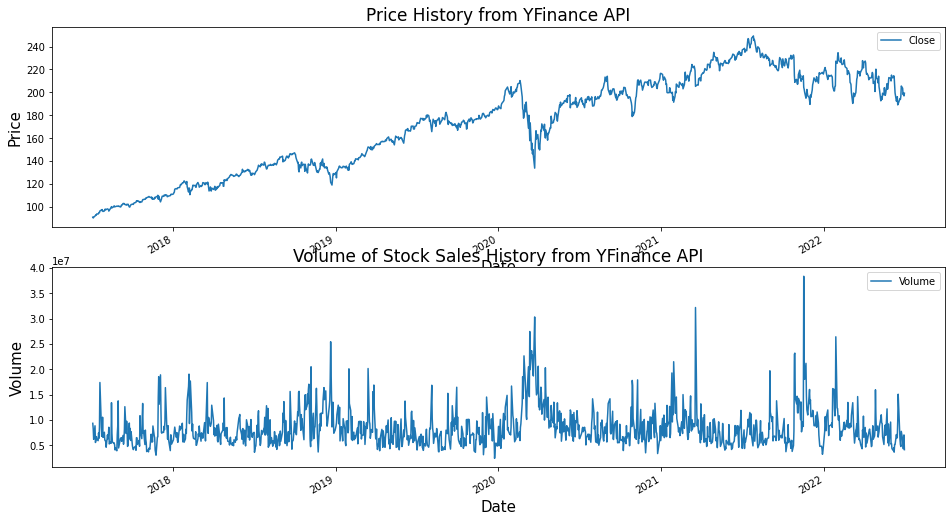

In [ ]:
stock = 'V'
years = 5
hist, recommendationKey, recom = stock_get_info(stock, years, plot = True)

# Technical Indicators

https://aiolux.com/reports/analytics-technical-indicators?symbol=V&tab_name=rsi

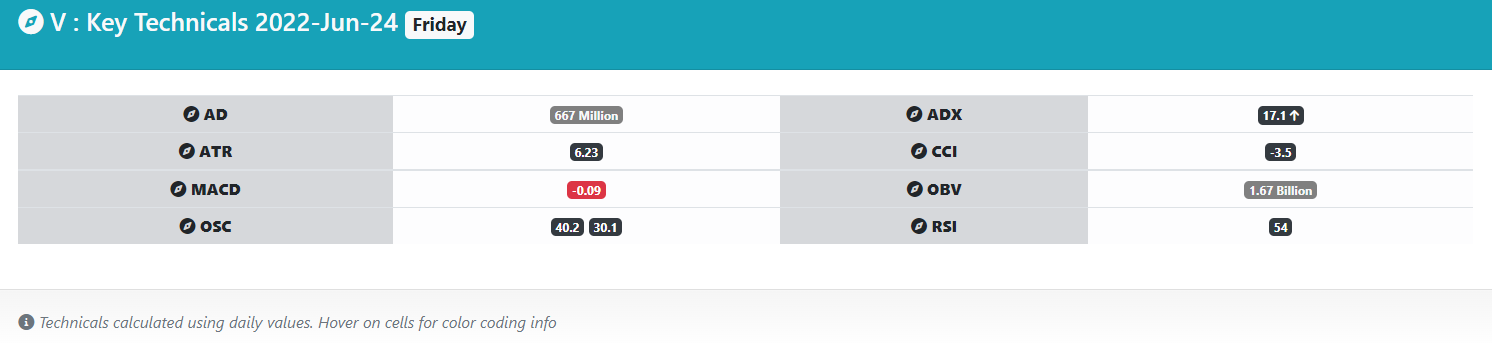

### Tentative Technical indicators

* RSI - Relative Strength Index oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30.

* MACD - Moving Average Convergence/Divergence indicator is a momentum oscillator.
MACD crossing above zero is considered bullish, while crossing below zero is bearish. Secondly, when MACD turns up from below zero it is considered bullish. When it turns down from above zero it is considered bearish.

* SMA - simple moving average.

* BB - Boilinger bands.




## Relative Strength Index (RSI) 

RSI - sell when the price is above the overbought threshold and buy when it’s below the oversold threshold. By adding the signal_indicators we get a True/False (0/1) if the price moves outside either of these thresholds. 

RSI_14_A_70	RSI_14_B_30	
These columns have 0 (False) values when the RSI is outside of these boundaries (above the RSI_14_A_70 and below the RSI_14_B_30) 

In [ ]:
hist = add_rsi_signal(hist, plot = True, showtables = True)

+----+--------------+---------+
|    | RSI_signal   |   count |
|----+--------------+---------|
|  0 | BUY          |      10 |
|  1 | HOLD         |    1141 |
|  2 | SELL         |      93 |
+----+--------------+---------+ 





+---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+
| Date                |   Open |   High |    Low |   Close |     Volume |   Daily_pct_change |   Daily_Volume_diff |   RSI_signal_factor |
|---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------|
| 2022-07-01 00:00:00 | 196.79 | 199.8  | 194.71 |  199.18 | 4.1314e+06 |          0.0116308 |         -2.9138e+06 |                   2 |
| 2022-06-30 00:00:00 | 195.37 | 198.85 | 192.85 |  196.89 | 7.0452e+06 |         -0.0130827 |          2.7206e+06 |                   2 |
| 2022-06-29 00:00:00 | 197.32 | 200.64 | 197.32 |  199.5  | 4.3246e+06 |          0.0069655 |     -29600          |                   2 |
+---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+ 



##Moving Average Convergence/Divergence indicator (MACD) 

In [ ]:
hist = add_MACD_signal(hist, plot = True, showtables = True)

+----+---------------+---------+
|    | MACD_Signal   |   count |
|----+---------------+---------|
|  0 | BUY           |      57 |
|  1 | HOLD          |    1131 |
|  2 | SELL          |      56 |
+----+---------------+---------+ 



+---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+----------------------+
| Date                |   Open |   High |    Low |   Close |     Volume |   Daily_pct_change |   Daily_Volume_diff |   RSI_signal_factor |   MACD_signal_factor |
|---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+----------------------|
| 2022-07-01 00:00:00 | 196.79 | 199.8  | 194.71 |  199.18 | 4.1314e+06 |          0.0116308 |         -2.9138e+06 |                   2 |                    2 |
| 2022-06-30 00:00:00 | 195.37 | 198.85 | 192.85 |  196.89 | 7.0452e+06 |         -0.0130827 |          2.7206e+06 |                   2 |                    2 |
| 2022-06-29 00:00:00 | 197.32 | 200.64 | 197.32 |  199.5  | 4.3246e+06 |          0.0069655 |     -29600          |                   2 |                    2 |
+---------------------+-----

##Simple Moving Average

+----+--------------+---------+
|    | SMA_Signal   |   count |
|----+--------------+---------|
|  0 | BUY          |       6 |
|  1 | HOLD         |    1232 |
|  2 | SELL         |       6 |
+----+--------------+---------+ 



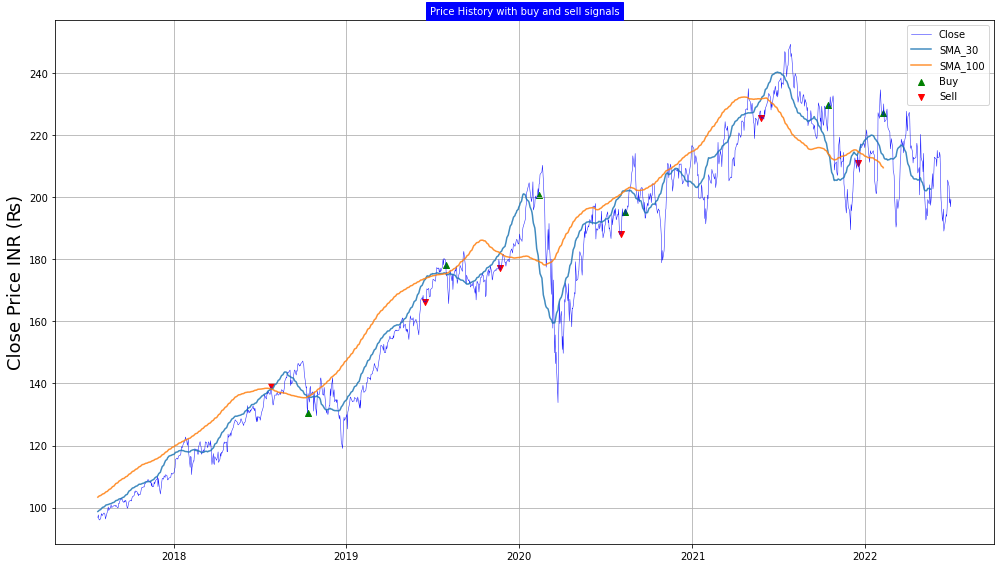

+---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+----------------------+---------------------+
| Date                |   Open |   High |    Low |   Close |     Volume |   Daily_pct_change |   Daily_Volume_diff |   RSI_signal_factor |   MACD_signal_factor |   SMA_Signal_factor |
|---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+----------------------+---------------------|
| 2022-07-01 00:00:00 | 196.79 | 199.8  | 194.71 |  199.18 | 4.1314e+06 |          0.0116308 |         -2.9138e+06 |                   2 |                    2 |                   2 |
| 2022-06-30 00:00:00 | 195.37 | 198.85 | 192.85 |  196.89 | 7.0452e+06 |         -0.0130827 |          2.7206e+06 |                   2 |                    2 |                   2 |
| 2022-06-29 00:00:00 | 197.32 | 200.64 | 197.32 |  199.5  | 4.3246e+06 |       

In [ ]:
hist = add_sma_signal(hist, short_period = 30, long_period = 100, plot = True, showtables = True)

##Bollinger bands

+----+-------------+---------+
|    | BB_Signal   |   count |
|----+-------------+---------|
|  0 | BUY         |      10 |
|  1 | HOLD        |    1225 |
|  2 | SELL        |       9 |
+----+-------------+---------+ 



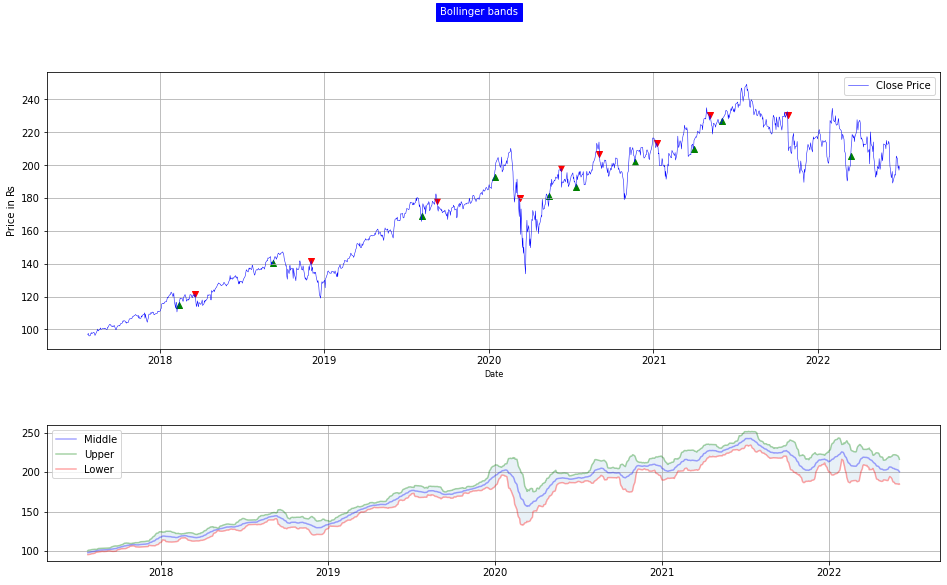

+---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+----------------------+---------------------+--------------------+
| Date                |   Open |   High |    Low |   Close |     Volume |   Daily_pct_change |   Daily_Volume_diff |   RSI_signal_factor |   MACD_signal_factor |   SMA_Signal_factor |   BB_Signal_factor |
|---------------------+--------+--------+--------+---------+------------+--------------------+---------------------+---------------------+----------------------+---------------------+--------------------|
| 2022-07-01 00:00:00 | 196.79 | 199.8  | 194.71 |  199.18 | 4.1314e+06 |          0.0116308 |         -2.9138e+06 |                   2 |                    2 |                   2 |                  2 |
| 2022-06-30 00:00:00 | 195.37 | 198.85 | 192.85 |  196.89 | 7.0452e+06 |         -0.0130827 |          2.7206e+06 |                   2 |                    2 |                   

In [ ]:
hist = add_bb_signal(hist,  plot= True, showtables = True)

#Modelling

## Target Variable

In [ ]:
hist= add_target_var_signal(hist, percentage_threshold = 1,  plot = True, showtables = True)

TARGET VARIABLE WITH A THRESHOLD OF +- 1 %

+----+-------------------+---------+
|    | pct_chnge_sgnal   |   count |
|----+-------------------+---------|
|  0 | BUY               |     243 |
|  1 | HOLD              |     726 |
|  2 | SELL              |     275 |
+----+-------------------+---------+ 





+---------------------+--------+--------+--------+---------+------------+---------------------+---------------------+----------------------+---------------------+--------------------+-------------------+
| Date                |   Open |   High |    Low |   Close |     Volume |   Daily_Volume_diff |   RSI_signal_factor |   MACD_signal_factor |   SMA_Signal_factor |   BB_Signal_factor |   target_variable |
|---------------------+--------+--------+--------+---------+------------+---------------------+---------------------+----------------------+---------------------+--------------------+-------------------|
| 2022-07-01 00:00:00 | 196.79 | 199.8  | 194.71 |  199.18 | 4.1314e+06 |         -2.9138e+06 |                   2 |                    2 |                   2 |                  2 |                 3 |
| 2022-06-30 00:00:00 | 195.37 | 198.85 | 192.85 |  196.89 | 7.0452e+06 |          2.7206e+06 |                   2 |                    2 |                   2 |                  2 

##Split data

In [ ]:
columns = ['Daily_Volume_diff','RSI_signal_factor','MACD_signal_factor','SMA_Signal_factor','BB_Signal_factor','target_variable']
X_train, X_test, y_train, y_test, today = split_data(hist, columns, test_size = 0.2)

COMPLETE SET: 100% 
ROWS:  1244  FROM  25-07-17  TO  01-07-22 
YEARS:  4.94

Complete set distribution of target variable
+----+-------------------+----------+-----------------------+
|    | target_variable   |   counts |   percentage_of_total |
|----+-------------------+----------+-----------------------|
|  0 | HOLD              |      726 |               58.3601 |
|  1 | SELL              |      275 |               22.1061 |
|  2 | BUY               |      243 |               19.5338 |
+----+-------------------+----------+-----------------------+

TRAIN SET: 80.0 % 
ROWS:  995  FROM  25-07-17  TO  07-07-21 
YEARS:  3.95

TEST SET: 20.0 % 
ROWS:   249  FROM  08-07-21  TO  01-07-22 
YEARS:  0.98

Train distribution of target variable
+----+-------------------+----------+-----------------------+
|    | target_variable   |   counts |   percentage_of_total |
|----+-------------------+----------+-----------------------|
|  0 | HOLD              |      608 |               61.1055 |
|  1 | 

##Random Forest Classifier

forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                max_depth=None, max_features='auto', max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                                oob_score=False, random_state=None, verbose=0,
                                warm_start=False)

In [ ]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
clas = classification_report(y_test, y_pred, output_dict=True)
clas = pd.DataFrame(clas).transpose()
print(tabulate(clas, headers='keys', tablefmt='psql'), "\n")

Accuracy: 0.41767068273092367
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 1            |    0.339623 | 0.264706 |   0.297521 |  68        |
| 2            |    0.5      | 0.610169 |   0.549618 | 118        |
| 3            |    0.269231 | 0.222222 |   0.243478 |  63        |
| accuracy     |    0.417671 | 0.417671 |   0.417671 |   0.417671 |
| macro avg    |    0.369618 | 0.365699 |   0.363539 | 249        |
| weighted avg |    0.397815 | 0.417671 |   0.403315 | 249        |
+--------------+-------------+----------+------------+------------+ 



In [ ]:
# Find the best parameters
parameters = {
    "n_estimators":[5,10,50,100,250],
}
grid_searcher = GridSearchCV(forest,parameters,cv=5)
grid_searcher.fit(X_train,y_train.values.ravel())
grid = pd.DataFrame(grid_searcher.cv_results_).sort_values('mean_test_score', ascending=False)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']].head(10)
print(tabulate(grid, headers='keys', tablefmt='psql'), "\n")

+----+-----------------------+-----------------+-------------------+-------------------+
|    | params                |   mean_fit_time |   mean_test_score |   rank_test_score |
|----+-----------------------+-----------------+-------------------+-------------------|
|  1 | {'n_estimators': 10}  |       0.0701613 |          0.474372 |                 1 |
|  0 | {'n_estimators': 5}   |       0.027644  |          0.472362 |                 2 |
|  2 | {'n_estimators': 50}  |       0.25575   |          0.468342 |                 3 |
|  3 | {'n_estimators': 100} |       0.490839  |          0.466332 |                 4 |
|  4 | {'n_estimators': 250} |       1.24665   |          0.465327 |                 5 |
+----+-----------------------+-----------------+-------------------+-------------------+ 



In [ ]:
forest = RandomForestClassifier(n_estimators=10, random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")
clas = classification_report(y_test, y_pred, output_dict=True)
clas = pd.DataFrame(clas).transpose()
print(tabulate(clas, headers='keys', tablefmt='psql'), "\n")

The accuracy of the model is 41.0 %
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 1            |    0.32     | 0.235294 |   0.271186 |  68        |
| 2            |    0.493333 | 0.627119 |   0.552239 | 118        |
| 3            |    0.244898 | 0.190476 |   0.214286 |  63        |
| accuracy     |    0.409639 | 0.409639 |   0.409639 |   0.409639 |
| macro avg    |    0.352744 | 0.350963 |   0.345904 | 249        |
| weighted avg |    0.38314  | 0.409639 |   0.389979 | 249        |
+--------------+-------------+----------+------------+------------+ 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



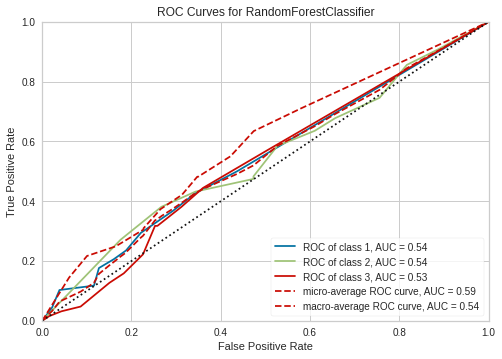

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb1652e8d0>,
       encoder={1: 1, 2: 2, 3: 3},
       estimator=RandomForestClassifier(n_estimators=10, random_state=42))

In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={1: 1, 
                                        2: 2, 
                                        3: 3})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer
plot_ROC_curve(forest, X_train, y_train, X_test, y_test)

Daily_Volume_diff     0.939582
RSI_signal_factor     0.026804
MACD_signal_factor    0.017233
BB_Signal_factor      0.011456
SMA_Signal_factor     0.004925
dtype: float64


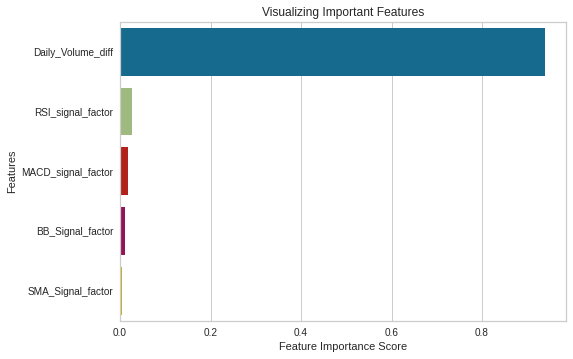

In [ ]:
feature_imp = pd.Series(forest.feature_importances_,index=hist[columns[:-1]].columns).sort_values(ascending=False)
print(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#Decision

In [ ]:
print(tabulate(today, headers='keys', tablefmt='psql'), "\n")

+---------------------+--------+--------+--------+---------+------------+---------------------+---------------------+----------------------+---------------------+--------------------+
| Date                |   Open |   High |    Low |   Close |     Volume |   Daily_Volume_diff |   RSI_signal_factor |   MACD_signal_factor |   SMA_Signal_factor |   BB_Signal_factor |
|---------------------+--------+--------+--------+---------+------------+---------------------+---------------------+----------------------+---------------------+--------------------|
| 2022-07-01 00:00:00 | 196.79 |  199.8 | 194.71 |  199.18 | 4.1314e+06 |         -2.9138e+06 |                   2 |                    2 |                   2 |                  2 |
+---------------------+--------+--------+--------+---------+------------+---------------------+---------------------+----------------------+---------------------+--------------------+ 



In [ ]:
print(f"\nYAHOO FINANCE RECOMENDATION: {recommendationKey}\n")
prediction = forest.predict(today[columns[:-1]])
print("MODEL PREDICTION:")
if(prediction == 1):
  print(prediction, " BUY")
elif (prediction==2):
  print(prediction," HOLD")
else:
  print(prediction," SELL")
print("\nLAST MARKET RECOMMENDATION:\n", recom[-1:])


YAHOO FINANCE RECOMENDATION: buy

MODEL PREDICTION:
[2]  HOLD

LAST MARKET RECOMMENDATION:
                        Firm To Grade From Grade Action
Date                                                  
2022-07-01 12:17:51  Mizuho  Neutral              main


In [ ]:
a = pd.DataFrame(recom["To Grade"].unique()).rename(columns={0:'decision'})
a["MARKET_DECISION"] = np.where((a.decision == "Buy") | (a.decision == "Outperform") | (a.decision == "Overweight") | (a.decision == "Positive") | (a.decision == "Market Perform") , "BUY", 
                                np.where((a.decision == "Hold") | (a.decision == "Sector Weight") | (a.decision == "Neutral"), "HOLD", "SELL" ))
a.sort_values(by = "MARKET_DECISION")

,decision,MARKET_DECISION
0,Buy,BUY
2,Outperform,BUY
3,Overweight,BUY
5,Market Perform,BUY
7,Positive,BUY
1,Neutral,HOLD
6,Hold,HOLD
8,Sector Weight,HOLD
4,Sell,SELL


In [ ]:
recom["MARKET_DECISION"] = np.where((recom["To Grade"] == "Buy") | (recom["To Grade"] == "Outperform") | (recom["To Grade"] == "Overweight") | (recom["To Grade"] == "Positive") | (recom["To Grade"] == "Market Perform") , "BUY", 
                                np.where((recom["To Grade"] == "Hold") | (recom["To Grade"] == "Sector Weight") | (recom["To Grade"] == "Neutral"), "HOLD", "SELL" ))
recom

,Firm,To Grade,From Grade,Action,MARKET_DECISION
Date,,,,,
2012-02-08 08:05:00,Stifel Nicolaus,Buy,,main,BUY
2012-02-09 06:45:00,Wedbush,Neutral,,main,HOLD
2012-02-09 07:05:00,Citigroup,Neutral,,main,HOLD
2012-02-09 07:06:00,Deutsche Bank,Buy,,main,BUY
2012-02-09 07:25:00,Oppenheimer,Outperform,,main,BUY
...,...,...,...,...,...
2022-04-27 11:34:55,Credit Suisse,Outperform,,main,BUY
2022-04-27 13:05:00,Morgan Stanley,Overweight,,main,BUY
2022-04-29 09:16:07,Piper Sandler,Neutral,Overweight,down,HOLD


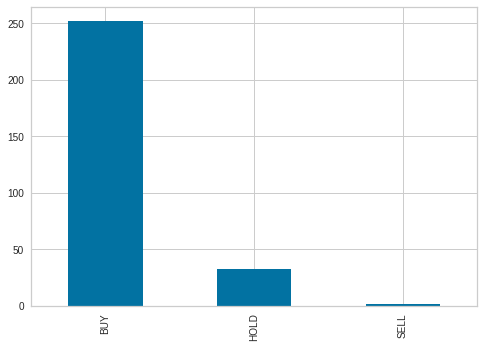

In [ ]:
recom.MARKET_DECISION.value_counts().plot.bar()

#Guidelines

1. Getting the data from the Bloomberg terminal – with long history
2. Calculating additional features: many technical indicators such as RSI, MACD, moving average etc.
3. Calculating the signals based on each of the indicators
Example: RSI between 30 – 70 nothing; below 30 buy, above 70 sell
https://www.investopedia.com/terms/r/rsi.asp
https://cointelegraph.com/news/here-s-3-ways-the-relative-strength-index-rsi-can-be-used-as-a-sell-signal
4. Later probably applying some feature selection methods here – Boruta, …
5. Calculate the BINARY target variable sell or buy e.g. based on the 1st differences day by day
6. Based on all of these signals train a classifier
7. Improve classification by parameter adjustments e.g. the boundaries 30 and 70

8. convert data to data series
www.alpharithms.com/relative-strength-index-rsi-in-python-470209/
10. Calculate technical indicators such as RSI
www.alpharithms.com/relative-strength-index-rsi-in-python-470209/
11. Stick with one asset

-----------------
-	Stick to a concrete example
-	Look up published results for RSI and other technical indicators with precise results
-	Compare number by number
-	Add more technical indicators
-	Following the rules of the indicators calculate ordinal variables with trading signals
-	Calculate a target variable on a daily basis such as sell / buy in case change above X%
-	Cut of 20% of the end(!) of the time series
-	Scenario 1
o	Based on the original technical indicators train a classifier on the 80% left
o	Evaluate model based on 20% new data
-	Scenario 2
o	Based on the trading signals generated apply the same procedure
-	Later we could improve the prediction based on NLP results and merge the predictions to get a final result

--------------

-	You started the feature engineering by calculating RSI
-	In the graph you defined the usual boundaries for RSI with 30 and 70?
-	This lead to a signal -> generate a new variable RSI_signal which is a factor: buy, hold, sell
-	Then we also need a target variable. I would suggest to create one as follows
o	daily difference equals e.g. 1 percent -> target_signal as factor sell, hold, buy
-	then we train a model  target_signal ~ RSI signal
o	random forrest
o	SVM
o	Cohonen network
-	Extend model target_signal ~ RSI signal + MACD signal + …
-	Having mor indicators at hand we could also try later to identify the most important ones
--------------------------------------
Please rearrange the script  and add a section to calculate the signals right after section Technical indicators. Yet it is in the section to create the target signal.

The target signal +/- 3 percent change is too much. You also can see this in the frequ. distribution
 
Please set to +/- 1 percent.

Please try out a random forest algorithm. Forget the decision tree.
Splitting is good for now. Later we can use a moving window / k-fold.

Please add other signals e.g. for MACD 
MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.

Or Bollinger Band
https://www.investopedia.com/terms/b/bollingerbands.asp

Moving Average could be another additional option.
But MA is related to MACD and the Length is not clear here. To get sensitive signals we should use a short length of 10 days. Could be worth it to test it because its so easy to calculate
https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp
